# New way to define the peaks and the, redo all the figures

## First run the function to detrend the time series later on 

### Function for doing spatial correlations/regressions:

#### This comes from http://hrishichandanpurkar.blogspot.com/2017/09/vectorized-functions-for-correlation.html


In [1]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

## Creating variables for the composite first

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import gsw
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from datetime import timedelta
from dateutil.relativedelta import relativedelta


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [3]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37683/status,
Dashboard: /proxy/37683/status,Workers: 7
Total threads: 28,Total memory: 126.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38843,Workers: 7
Dashboard: /proxy/37683/status,Total threads: 28
Started: Just now,Total memory: 126.00 GiB
Comm: tcp://127.0.0.1:37387,Total threads: 4
Dashboard: /proxy/44529/status,Memory: 18.00 GiB
Nanny: tcp://127.0.0.1:39573,


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### Creating variables for time series

#### TEMPERATURE BOX 1

In [5]:
# load temperature data at 400m:

depth_slice = slice(400, 6000)
# cut the data BOX 1
lon_slice  = slice(-252.7, -251.7)
lat_slice  = slice(-65.35, -65.1)

temp_400m = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_400m = temp_400m.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=depth_slice)

In [6]:
# depth average:
# there is no dzu saved
# calculate grid thickness, adjusted for partial cells:
zlevel1 = 400
zlevel2 = 6000

# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(iaf_cycle3,'st_edges_ocean',master_session,
                 start_time=start_time, end_time=end_time,n=1)
st_edges_array = st_edges_ocean.expand_dims({'yt_ocean':temp_400m.yt_ocean,'xt_ocean':temp_400m.xt_ocean},axis=[1,2])
# import bathymetry:
ht = cc.querying.getvar(iaf_cycle3,'ht',master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ht,other=ht)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(iaf_cycle3,'st_ocean',master_session,n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))

# select correct depths:
thickness = thickness.sel(st_ocean=slice(zlevel1,zlevel2))

# multiply by thickness to avg
temp_400m = (temp_400m*thickness).sum('st_ocean')/thickness.sum('st_ocean')

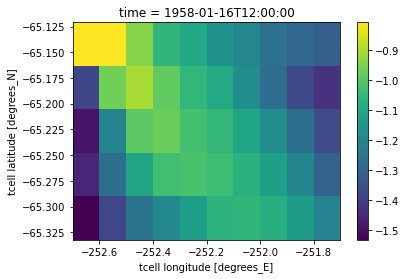

In [7]:
##test if temp is still working after the depth weighting
temp_400m[0,...].plot()

In [8]:
#AREA WEIGHTING #area t cant be found at iaf_cycle3
# area weighting:
area_t = cc.querying.getvar('01deg_jra55v13_ryf9091','area_t',master_session, ncfile = 'ocean_grid.nc',n=-1)
area_t = area_t.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

# sum area:
area_t_sum = area_t.sum('xt_ocean').sum('yt_ocean')

# Apply area weight:
temp_400m = (temp_400m*area_t).sum('xt_ocean').sum('yt_ocean')/area_t_sum



In [9]:
temp_400m_za=temp_400m.load()

In [10]:
### make it a data array again because it is being difficult to handle the dates as limits. 
temp_400m_za= xr.DataArray(temp_400m_za,
                   coords={'time': temp_400m.time},
                   dims=["time"])

top=np.full((732,), -0.6)
top= xr.DataArray(top,
                   coords={'time': temp_400m.time},
                   dims=["time"])
top=top.load()

bottom = np.full((732,), -1.33)

bottom = xr.DataArray(bottom,
                   coords={'time': temp_400m.time},
                   dims=["time"])
bottom=bottom.load()

### Creating variables for time series

#### TEMPERATURE BOX 1

### test of possible threasholds

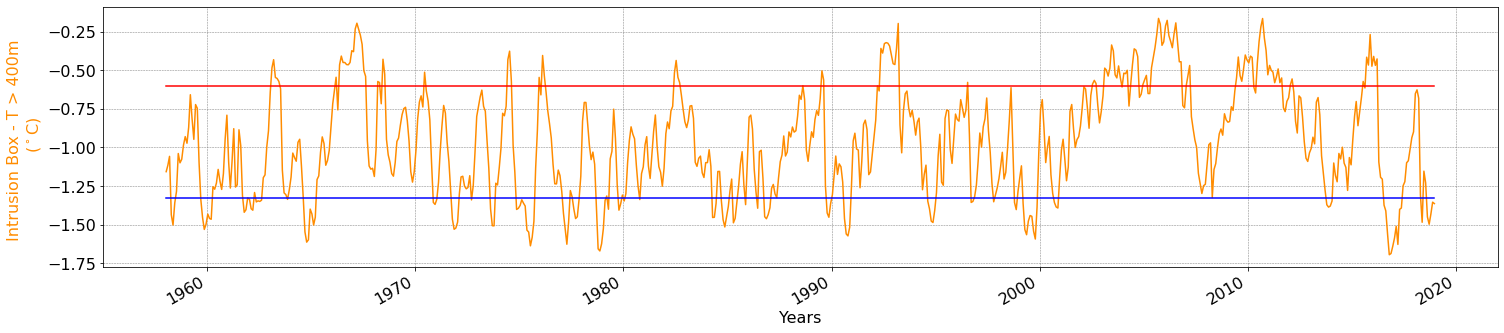

In [12]:
fontsize=16

fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)
ax1 = plt.subplot(4, 1, 2)
temp_400m_za.plot(color='darkorange')
top.plot(color='r')
bottom.plot(color='b')
#plt.plot([1963,1963],[-1.4,-0.3],color='gray',linestyle='--')
plt.tick_params(labelsize=fontsize)
#ax1.xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Years',fontsize=fontsize)
ax1.set_ylabel('Intrusion Box - T > 400m \n ($^\circ$C)', fontsize=fontsize,color='darkorange')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#plt.xlim(temp_400m_za.time[0],temp_400m_za.time[731])
#plt.ylim(-1.4,-0.3)


#figdir = '/home/581/ns3783/Scripts/Figures/New_Codes_CFD'
#filestr = figdir+'/roll_temp_series.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [11]:
rho_thresh = -0.6

ind=np.arange(732)
# mask density where < rho_thresh:
t_mask = temp_400m_za.where(temp_400m_za>rho_thresh)

# # Now find first depth where sigma0_off_mask is not masked:
time_array =  temp_400m_za*0 + ind
# # mask depth array usying density threshold:
time_array_masked_top = time_array.where(temp_400m_za>rho_thresh)


In [12]:
nan_array = np.isnan(time_array_masked_top)
not_nan_array = ~ nan_array
top_index = time_array_masked_top[not_nan_array]
print(top_index)

<xarray.DataArray (time: 131)>
array([ 61.,  62.,  63.,  64.,  65.,  98., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       122., 123., 125., 126., 149., 197., 198., 199., 215., 217., 218.,
       293., 294., 295., 296., 378., 379., 412., 413., 414., 415., 416.,
       417., 418., 419., 420., 421., 422., 462., 534., 535., 536., 541.,
       542., 543., 544., 545., 546., 547., 548., 549., 550., 552., 553.,
       554., 556., 557., 558., 559., 560., 563., 564., 565., 568., 569.,
       570., 571., 572., 573., 574., 575., 576., 577., 578., 579., 580.,
       581., 582., 583., 584., 585., 588., 589., 590., 617., 618., 619.,
       620., 621., 622., 623., 624., 625., 626., 629., 630., 631., 632.,
       633., 634., 635., 636., 637., 638., 639., 640., 641., 642., 643.,
       648., 649., 690., 692., 693., 694., 695., 696., 697., 698.])
Coordinates:
  * time     (time) datetime64[ns] 1963-02-15 ... 2016-03-16T12:00:00


In [13]:
top_id=top_index.astype(int)

In [14]:
temp_400m_za[top_id]

<xarray.DataArray (time: 131)>
array([-0.48511424, -0.43214546, -0.54703545, -0.55377832, -0.5725696 ,
       -0.54594482, -0.46570798, -0.4088136 , -0.45050449, -0.45030083,
       -0.46368757, -0.46522606, -0.45046361, -0.37401438, -0.38040226,
       -0.23314956, -0.19598735, -0.23479929, -0.27434144, -0.33317187,
       -0.50359372, -0.54009589, -0.57328546, -0.58008781, -0.42941849,
       -0.52612348, -0.51341127, -0.43132035, -0.37706868, -0.57189479,
       -0.54682661, -0.40491637, -0.53601462, -0.51822929, -0.43715221,
       -0.54600163, -0.58154576, -0.50429785, -0.56394059, -0.35924394,
       -0.3895315 , -0.32815712, -0.32161105, -0.32541214, -0.34398512,
       -0.39937769, -0.45812845, -0.46363683, -0.35633012, -0.19766935,
       -0.57900156, -0.58973354, -0.56614371, -0.58660648, -0.48680219,
       -0.49913885, -0.53824884, -0.48660689, -0.33698434, -0.37515616,
       -0.53003568, -0.550283  , -0.47269499, -0.54857951, -0.51956437,
       -0.52248623, -0.5006165 , -0.59076402, -0.4639518 , -0.36173663,
       -0.37083595, -0.41220725, -0.59276766, -0.56134594, -0.53383775,
       -0.48380178, -0.41832106, -0.35397534, -0.26943103, -0.16485962,
       -0.20124962, -0.33925135, -0.3168452 , -0.21368584, -0.17753436,
       -0.27544092, -0.31272568, -0.35463907, -0.26380331, -0.1938767 ,
       -0.31971458, -0.44583377, -0.44550371, -0.59726497, -0.5317501 ,
       -0.46961471, -0.54890582, -0.41492123, -0.53508245, -0.57192113,
       -0.49370245, -0.40177501, -0.43366975, -0.45335717, -0.40891284,
       -0.41760776, -0.45293056, -0.31384188, -0.21972138, -0.16556052,
       -0.29066373, -0.37243931, -0.53016887, -0.4693896 , -0.5010934 ,
       -0.51275872, -0.58138501, -0.54417364, -0.49192018, -0.58112038,
       -0.55035479, -0.59473695, -0.55678964, -0.57314081, -0.4159892 ,
       -0.46699094, -0.26936861, -0.47457743, -0.41089855, -0.46909475,
       -0.42725546])
Coordinates:
  * time     (time) datetime64[ns] 1963-02-15 ... 2016-03-16T12:00:00

In [15]:
rho_thresh = -1.33 #used to be -1.4

ind=np.arange(732)
# mask density where < rho_thresh:
t_mask = temp_400m_za.where(temp_400m_za<rho_thresh)

# # Now find first depth where sigma0_off_mask is not masked:
time_array =  temp_400m_za*0 + ind
# # mask depth array usying density threshold:
time_array_masked_bt = time_array.where(temp_400m_za<rho_thresh)

In [16]:
nan_array = np.isnan(time_array_masked_bt)
not_nan_array = ~ nan_array
bt_index = time_array_masked_bt[not_nan_array]
print(bt_index)

<xarray.DataArray (time: 135)>
array([  3.,   4.,   5.,  20.,  21.,  22.,  23.,  24.,  25.,  26.,  45.,
        46.,  48.,  49.,  50.,  52.,  53.,  54.,  55.,  70.,  80.,  81.,
        82.,  83.,  84.,  85.,  86., 154., 155., 156., 165., 166., 167.,
       168., 176., 187., 188., 189., 202., 203., 204., 205., 206., 207.,
       208., 209., 210., 211., 212., 229., 230., 231., 232., 235., 236.,
       237., 238., 248., 249., 250., 251., 252., 253., 255., 261., 262.,
       264., 273., 315., 316., 317., 320., 321., 322., 323., 324., 327.,
       328., 329., 334., 341., 345., 346., 347., 348., 381., 382., 383.,
       391., 392., 393., 394., 439., 440., 441., 442., 443., 464., 465.,
       477., 489., 490., 494., 495., 496., 497., 498., 499., 500., 501.,
       502., 512., 513., 514., 669., 670., 671., 672., 702., 703., 704.,
       705., 706., 707., 708., 709., 710., 711., 712., 724., 727., 728.,
       729., 730., 731.])
Coordinates:
  * time     (time) datetime64[ns] 1958-04-16 ... 2018

In [17]:
bt_id=bt_index.astype(int)

In [18]:
temp_400m_za[bt_id]

<xarray.DataArray (time: 135)>
array([-1.43597099, -1.5025915 , -1.35969613, -1.33681947, -1.45362495,
       -1.53125441, -1.49790952, -1.43202489, -1.46005087, -1.46540674,
       -1.42018816, -1.40383009, -1.33571061, -1.3970073 , -1.40667889,
       -1.35323161, -1.3462152 , -1.3500104 , -1.34208419, -1.33652893,
       -1.54733664, -1.61350984, -1.59825458, -1.39962008, -1.43109048,
       -1.50266292, -1.45239901, -1.35618848, -1.36924816, -1.33595763,
       -1.46474031, -1.53034358, -1.52209248, -1.48351704, -1.34016941,
       -1.39873917, -1.50701585, -1.50796601, -1.40181682, -1.39470875,
       -1.37627128, -1.339124  , -1.36076197, -1.37985885, -1.53568305,
       -1.54844226, -1.63737312, -1.58258276, -1.47870622, -1.42562401,
       -1.5268779 , -1.62704667, -1.484363  , -1.39937697, -1.46082593,
       -1.44906261, -1.33731838, -1.38086987, -1.65715983, -1.67050328,
       -1.62421652, -1.5251953 , -1.34408225, -1.40039137, -1.40653129,
       -1.36573912, -1.34715576, -1.33790019, -1.45393608, -1.45261532,
       -1.3623173 , -1.34359112, -1.46733087, -1.51532897, -1.44937974,
       -1.38294054, -1.4883785 , -1.45938955, -1.3522498 , -1.37064155,
       -1.39403056, -1.44876096, -1.46214195, -1.43570771, -1.39130935,
       -1.42451743, -1.45245587, -1.36354968, -1.46068621, -1.5604725 ,
       -1.57302797, -1.5167263 , -1.34767632, -1.39810911, -1.47731771,
       -1.48655621, -1.408503  , -1.35661018, -1.34988597, -1.35226105,
       -1.3567266 , -1.40283876, -1.36402811, -1.532371  , -1.56544682,
       -1.47789018, -1.44123228, -1.44619941, -1.54231497, -1.59338771,
       -1.38744939, -1.35736432, -1.38585147, -1.39272258, -1.37143886,
       -1.38670622, -1.37978885, -1.34695631, -1.37376857, -1.41126867,
       -1.55910246, -1.69509413, -1.68698347, -1.64021676, -1.58619811,
       -1.5109053 , -1.62828427, -1.40123948, -1.39251907, -1.48475835,
       -1.45020066, -1.49757037, -1.43162962, -1.35467032, -1.36392024])
Coordinates:
  * time     (time) datetime64[ns] 1958-04-16 ... 2018-12-16T12:00:00

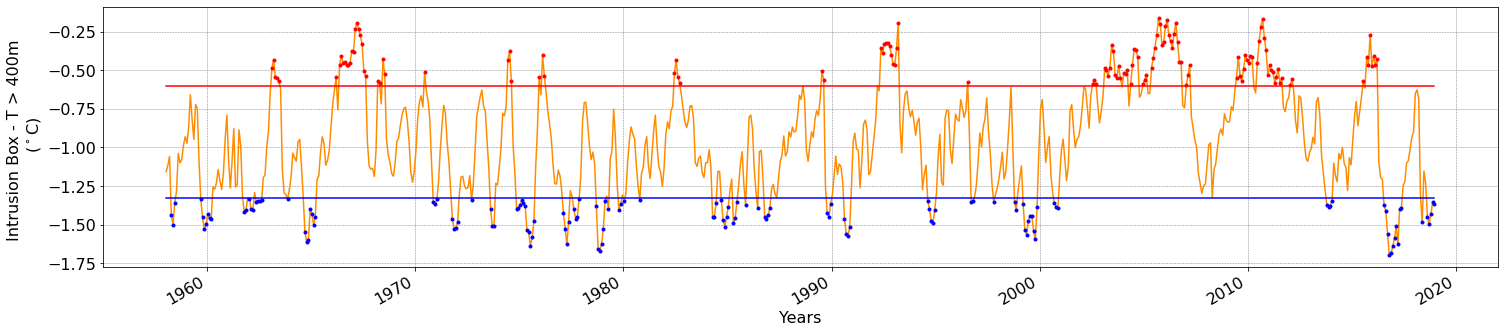

In [23]:
fontsize=16

fig=plt.figure(figsize=(25, 22))
fig.subplots_adjust(top=0.88)
ax1 = plt.subplot(4, 1, 2)
temp_400m_za.plot(color='darkorange')
temp_400m_za[bt_id].plot(marker='.',color='blue',linestyle='none')
temp_400m_za[top_id].plot(marker='.',color='red',linestyle='none')
top.plot(color='r')
bottom.plot(color='b')
#plt.plot([1963,1963],[-1.4,-0.3],color='gray',linestyle='--')
plt.tick_params(labelsize=fontsize)
#ax1.xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Years',fontsize=fontsize)
ax1.set_ylabel('Intrusion Box - T > 400m \n ($^\circ$C)', fontsize=fontsize)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

#plt.xlim(temp_400m_za['time'][0],temp_400m_za['time'][731]+1) #this is a great work around
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig1_timeseries_no_roll.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

## MAKE INDEX SHIFTED 2 MONTHS PRIOR -needed for Fig5

In [19]:
top_index

<xarray.DataArray (time: 131)>
array([ 61.,  62.,  63.,  64.,  65.,  98., 100., 101., 102., 103., 104.,
       105., 106., 107., 108., 109., 110., 111., 112., 113., 114., 115.,
       122., 123., 125., 126., 149., 197., 198., 199., 215., 217., 218.,
       293., 294., 295., 296., 378., 379., 412., 413., 414., 415., 416.,
       417., 418., 419., 420., 421., 422., 462., 534., 535., 536., 541.,
       542., 543., 544., 545., 546., 547., 548., 549., 550., 552., 553.,
       554., 556., 557., 558., 559., 560., 563., 564., 565., 568., 569.,
       570., 571., 572., 573., 574., 575., 576., 577., 578., 579., 580.,
       581., 582., 583., 584., 585., 588., 589., 590., 617., 618., 619.,
       620., 621., 622., 623., 624., 625., 626., 629., 630., 631., 632.,
       633., 634., 635., 636., 637., 638., 639., 640., 641., 642., 643.,
       648., 649., 690., 692., 693., 694., 695., 696., 697., 698.])
Coordinates:
  * time     (time) datetime64[ns] 1963-02-15 ... 2016-03-16T12:00:00

In [23]:
top_index_sh=top_index-2
bt_index_sh=bt_index-2

In [25]:
bt_id_sh=bt_index_sh.astype(int)
top_id_sh=top_index_sh.astype(int)

### saving arrays

In [22]:
ds = xr.Dataset({'top_id':top_id})
outpath = '/g/data/v45/ns3783/top_index.nc'
ds.to_netcdf(outpath)

In [23]:
ds = xr.Dataset({'bt_id':bt_id})
outpath = '/g/data/v45/ns3783/bottom_index.nc'
ds.to_netcdf(outpath)

In [26]:
ds = xr.Dataset({'bt_id_sh':bt_id_sh})
outpath = '/g/data/v45/ns3783/bottom_index_sh.nc'
ds.to_netcdf(outpath)

In [27]:
ds = xr.Dataset({'top_id_sh':top_id_sh})
outpath = '/g/data/v45/ns3783/top_index_sh.nc'
ds.to_netcdf(outpath)

### Opening arrays that select the picks for low and high intrusion months

In [83]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [84]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

### opening arrays

In [24]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [25]:
top_id

<xarray.DataArray 'top_id' (time: 131)>
array([ 61,  62,  63,  64,  65,  98, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 122, 123, 125, 126, 149, 197,
       198, 199, 215, 217, 218, 293, 294, 295, 296, 378, 379, 412, 413, 414,
       415, 416, 417, 418, 419, 420, 421, 422, 462, 534, 535, 536, 541, 542,
       543, 544, 545, 546, 547, 548, 549, 550, 552, 553, 554, 556, 557, 558,
       559, 560, 563, 564, 565, 568, 569, 570, 571, 572, 573, 574, 575, 576,
       577, 578, 579, 580, 581, 582, 583, 584, 585, 588, 589, 590, 617, 618,
       619, 620, 621, 622, 623, 624, 625, 626, 629, 630, 631, 632, 633, 634,
       635, 636, 637, 638, 639, 640, 641, 642, 643, 648, 649, 690, 692, 693,
       694, 695, 696, 697, 698])
Coordinates:
  * time     (time) datetime64[ns] 1963-02-15 ... 2016-03-16T12:00:00

In [26]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

In [27]:
bt_id

<xarray.DataArray 'bt_id' (time: 135)>
array([  3,   4,   5,  20,  21,  22,  23,  24,  25,  26,  45,  46,  48,  49,
        50,  52,  53,  54,  55,  70,  80,  81,  82,  83,  84,  85,  86, 154,
       155, 156, 165, 166, 167, 168, 176, 187, 188, 189, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 229, 230, 231, 232, 235, 236, 237,
       238, 248, 249, 250, 251, 252, 253, 255, 261, 262, 264, 273, 315, 316,
       317, 320, 321, 322, 323, 324, 327, 328, 329, 334, 341, 345, 346, 347,
       348, 381, 382, 383, 391, 392, 393, 394, 439, 440, 441, 442, 443, 464,
       465, 477, 489, 490, 494, 495, 496, 497, 498, 499, 500, 501, 502, 512,
       513, 514, 669, 670, 671, 672, 702, 703, 704, 705, 706, 707, 708, 709,
       710, 711, 712, 724, 727, 728, 729, 730, 731])
Coordinates:
  * time     (time) datetime64[ns] 1958-04-16 ... 2018-12-16T12:00:00

In [28]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or 
    for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
     
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

# detrending function:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit